In [387]:
from init import *
from fiona.crs import from_epsg
import folium
import time 

In [3]:
import ee
ee.Authenticate()

Enter verification code: 4/tAHfIQrrw6HEsCIAhpH_EQi3hsNCEDeFkVO1BUIINh2E7ooLsHSUcoU

Successfully saved authorization token.


In [4]:
# Initialize the library.
ee.Initialize()

In [5]:
# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
print('Folium version: ' + folium.__version__)

Folium version: 0.10.0


In [200]:
def mapshow(mapid, location, name='composite'):
    EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
    fmap = folium.Map(location=location)
    folium.TileLayer(
        tiles   = EE_TILES.format(**mapid),
        attr    = 'Google Earth Engine',
        overlay = True,
        name    = name).add_to(fmap)
    fmap.add_child(folium.LayerControl())
    return fmap 

#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
        if ee.image.Image in [type(x) for x in v.values()]:
            folium.TileLayer(
                tiles = EE_TILES.format(**v),
                attr  = 'Google Earth Engine',
                overlay =True,
                name  = k
              ).add_to(mapViz)
        else:
            folium.GeoJson(
            data = v,
            name = k
              ).add_to(mapViz)
            mapViz.add_child(folium.LayerControl())
            return mapViz

# Cloud masking function.
def maskL8sr(image):
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
    cloudShadowBitMask = ee.Number(2).pow(3).int()
    cloudsBitMask = ee.Number(2).pow(5).int()
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
     qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask).select(bands).divide(10000)

In [352]:
# Prepare tripura shapefile
nest = gpd.read_file('/home/pankaj/phd/practice/sur/data/neshpfile/NE_utm.shp')
nest = nest.to_crs(from_epsg(4326))
# trip = nest.dissolve(by='ISO').geometry.to_json()
trip = nest[nest.NAME_1 == 'Tripura'].geometry.to_json()
tcor = eval(trip)['features'][0]['geometry']['coordinates'][0]
eetrip = ee.FeatureCollection([ee.Feature(ee.Geometry.Polygon(tcor),{'Name':'Tripura'})])
center = eetrip.geometry().centroid().getInfo()['coordinates'][::-1]
region = eetrip.geometry().getInfo()['coordinates']

In [353]:
# LANDSAT 8
bands = ['B5', 'B4', 'B3']
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
image = l8sr.filterDate('2017-01-01', '2017-12-31')
image = image.map(maskL8sr).median().clip(eetrip).select(bands)

In [434]:
label  = 'Class'
labels = ee.FeatureCollection("users/pankajkmr1990/train").filterBounds(eetrip)#.limit(1000)
#labels = labels.remap([1, 2, 3, 4, 5], [0, 1, 2, 3, 4], label)
sample = image.sampleRegions(collection=labels, \
                             properties=[label], \
                             scale=100, tileScale=16)
classifier = ee.Classifier.svm(kernelType='RBF', gamma=0.5, cost=10)
trained    = classifier.train(sample, label, bands)
classified = image.classify(trained)

In [435]:
#labels = ['water', 'cropland', 'forest', 'built-up', 'snow']
palette = ['blue', 'orange', 'green', 'red', 'white']
#palette = ['aec3d4', 'cdb33b', '152106', 'cc0013', 'd7cdcc']
mapid1 = image.getMapId({'min': 0, 'max': 0.5})
mapid2 = classified.getMapId({'min': 1, 'max': 5, 'palette': palette})

In [328]:
mapshow(mapid1, center, name='original')

In [436]:
mapshow(mapid2, center, name='Classified')

In [280]:
image.getThumbURL({'min': 0, 'max': 0.5, \
                   'region': region,\
                   'crs': 'EPSG:3857'})

'https://earthengine.googleapis.com/api/thumb?thumbid=113fe5332ae0aa8363c9ece2bc6415ff&token=4809a48f16be2412d0864c31892f39b3'

In [357]:
classified.getThumbURL({'min': 0, 'max': 4, \
                        'palette': palette, \
                        'region': region,\
                        'crs': 'EPSG:3857'})

'https://earthengine.googleapis.com/api/thumb?thumbid=5e330ab3177f62d48c242c08cee8cc1c&token=0754fbcffc16bfc7d754dbab76087de3'

In [446]:
# Export the image, specifying scale and region.
task = ee.batch.Export.image.toDrive(**{
    'image': image,
    'description': 'landsat2018',
    'folder':'gee',
    'fileFormat': 'GeoTIFF',
    'scale': 100,
    'region': region
})

task.start()
while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(5)

Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).
Polling for task (id: HN2F5KNKNQZZHPLFVZ7OAXZK).


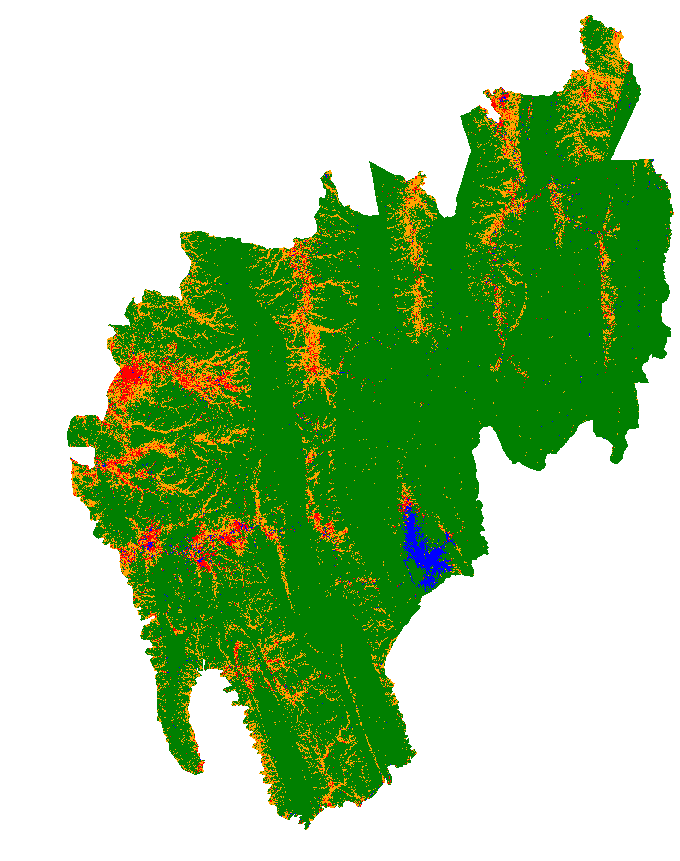

In [450]:
import rasterio
from matplotlib.colors import ListedColormap
colors = ['white', 'blue', 'orange', 'green', 'red']
cmap = ListedColormap(colors)
im = rasterio.open('/home/pankaj/Desktop/class2018.tif').read(1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(im, cmap=cmap)
ax.axis('off')
plt.show()